# Download plant spectra using ECOSIS API and species list
This jupyter notebook shows how to access [ECOSIS](https://ecosis.org/) API and retrieve data/create visualizations. The API documentation is provided here:http://cstars.github.io/ecosis/.

First, import python modules.

In [1]:
import requests
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Plant latin names
The latin names of 2 plant species are provided in the CSV file `plant_latin.csv`. 

In [2]:
# read plant_latin.csv
plant_df =pd.read_csv("plant_latin2.csv")
# print first two rows
plant_df[:2]

,Latin Genus,Latin Species
0,acer,negundo
1,acer,rubrum


## Search ECOSIS
We will search for ECOSIS database for the spectra data by their latin names.  

In [3]:
# base URL of ECOSIS API
baseurl = "https://ecosis.org/api"

# data API url
dataurl = f"{baseurl}/package"

# search API url
searchurl = f"{dataurl}/search"

# list to save dataset_ids
dataset_id = []

# loop through the plant names and search datasets
for i in plant_df.index:
        
    # defining search parameters
    searchjson = {"filters": f'[{plant_df.loc[i].to_json()}]',
                 "start":0,
                 "stop":100}

    # needed to maintain spaces in search parameters
    params = urllib.parse.urlencode(searchjson, quote_via=urllib.parse.quote)

    # submit request
    response = requests.get(searchurl, params=params)
    response.raise_for_status()
    
    # remove the dataset that have "DO NOT USE" labels in descriptions and get their ids (`_id`).
    for item in response.json()['items']:
        if ("DO NOT USE" not in item['ecosis']['description']):
            dataset_id.append(item['_id'])

# keep unique dataset ids
dataset_id = list(set(dataset_id))

# print total spectra
print(f"A total of {len(dataset_id)} datasets found for {len(plant_df.index)} species.")

A total of 26 datasets found for 65 species.


## Get Statistics
The `dataset_id` above now contains the list of datasets that has one of the 65 species of interest. 

Statistics endpoint `/stats` of the ECOSIS API gives sum, count, min, max, avg, variance and stddev of the dataset. We will now loop through all datasets and plot the average spectra value as well as its stddev as error bands and see if there are any anomalous datasets. Note that these dataset includes spectra from all species (not only 65 species from the csv file above).

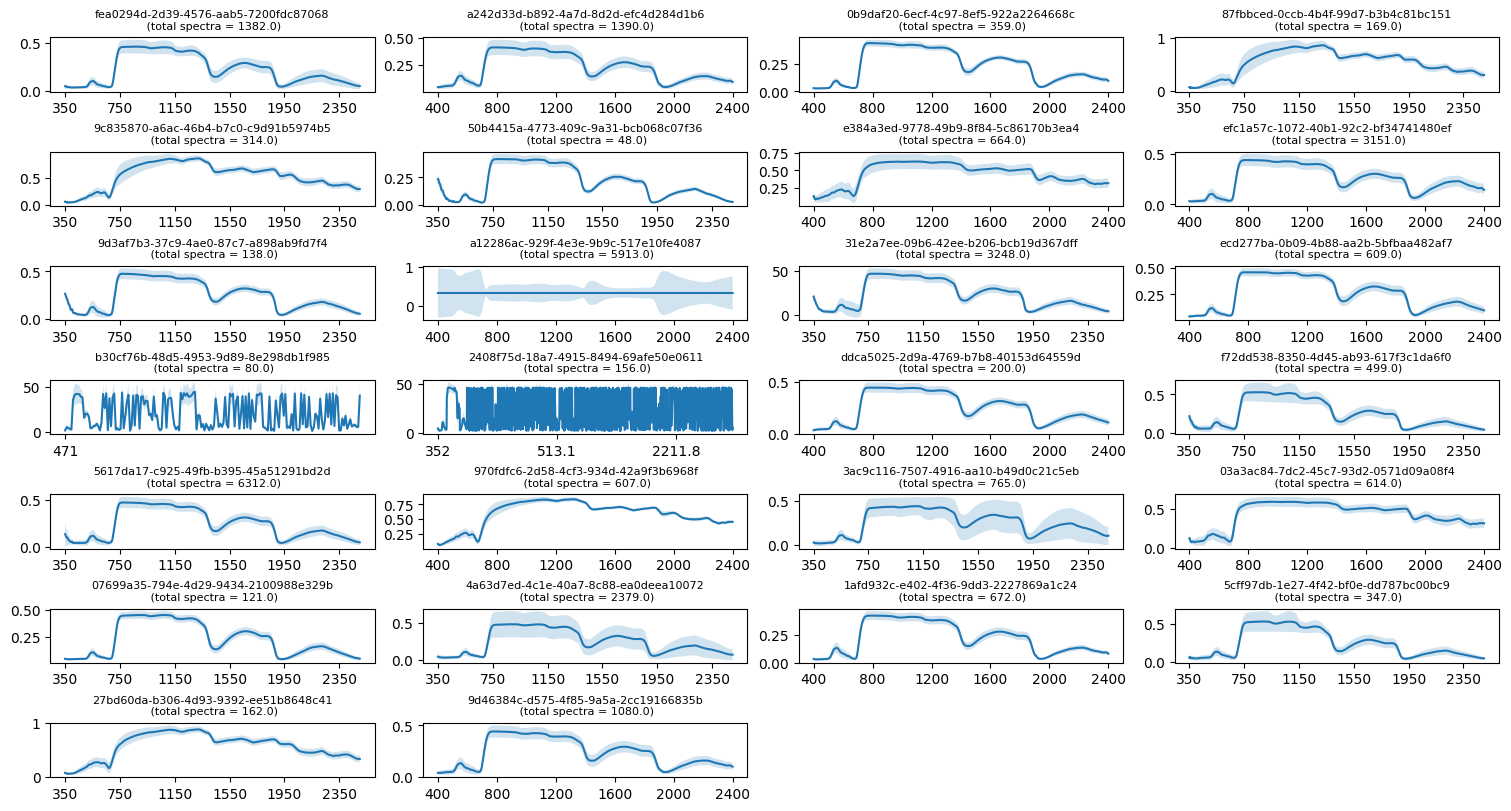

In [4]:
# spectra API url
staturl = f"{baseurl}/spectra/stats"
fig=plt.figure(figsize=(15,8), constrained_layout = True)

columns = 4
rows = int(len(dataset_id)/columns)+1
for i in range(1, len(dataset_id)+ 1):
    # submit request
    response = requests.get(f"{staturl}/{dataset_id[i-1]}")
#     print(f"{dataset_id[i-1]}")
    response.raise_for_status()
    
    # keep the data to json
    df = pd.json_normalize(response.json(), max_level=0).T
    df = pd.concat([df.drop(columns=df.columns[0], axis=1), df[df.columns[0]].apply(pd.Series)], axis=1)
    
    ax = fig.add_subplot(rows, columns, i)
    ax.plot(df.index, df['avg'])
    ax.fill_between(df.index, df['avg']-df['stddev'], df['avg']+df['stddev'], alpha=0.2)
    ax.set_xticks(ax.get_xticks()[::400])
    ax.set_title(f"{dataset_id[i-1]}\n (total spectra = {df['count'].iloc[0]})", fontsize=8)

plt.show()

In the figures above we see that three datasets (`a12286ac-929f-4e3e-9b9c-517e10fe4087`, `2408f75d-18a7-4915-8494-69afe50e0611`, and `b30cf76b-48d5-4953-9d89-8e298db1f985`) have somewhat different looking spectra. These dataset likely have issues with them. Let's remove these datasets from the `dataset_id` list.

In [5]:
ds_remove = ["a12286ac-929f-4e3e-9b9c-517e10fe4087", "2408f75d-18a7-4915-8494-69afe50e0611", "b30cf76b-48d5-4953-9d89-8e298db1f985"]
dataset_id = list(set(dataset_id) - set(ds_remove))
print(f"A total of {len(dataset_id)} datasets are left after removing poor-quality datasets.")

A total of 23 datasets are left after removing poor-quality datasets.


## Get dataset/spectra
Now, let's retrieve all spectra in the first three datasets from the `dataset_id` list above. This step will probably take long time depending on number of spectra available within the datasets.

In [6]:
# spectra API url
spectraurl = f"{baseurl}/spectra/search"

# initialize pandas dataframe
spectra_df = pd.DataFrame() 

# total number of spectra
spectra_n = 0 

# ########################
# loop through the dataset_id and retrieve spectra
# IMPORTANT: CHANGE TO dataset_id[:] TO RETRIEVE SPECTRA FROM ALL DATASETS
#####################
for ds_id in dataset_id[:3]: 
    # submit request
    response = requests.get(f"{dataurl}/{ds_id}")
    response.raise_for_status()

    # total number of spectra
    spectra_n += int(response.json()['ecosis']['spectra_count'])
    
    # the api only allows 100 items at a time
    # this loop is for pagination
    for start in range(0, spectra_n+1, 100):
        spectrajson = {"start":start, "stop":start + 99}

        # needed to maintain spaces in search parameters
        params = urllib.parse.urlencode(spectrajson, quote_via=urllib.parse.quote)

        # submit request
        response = requests.get(f"{spectraurl}/{ds_id}", params=params)
        response.raise_for_status()

        for item in response.json()['items']:
            # keep only species that are of interest
            for i in plant_df.index:
                if ((item.get('Latin Genus') == plant_df['Latin Genus'][i].capitalize()) 
                    and (item.get('Latin Species') == plant_df['Latin Species'][i])):
                    
                    # getting spectra
                    dummy_df = pd.json_normalize(item['datapoints']).apply(pd.to_numeric)
                    # species name
                    dummy_df['Latin Genus'] = item['Latin Genus']
                    dummy_df['Latin Species'] = item['Latin Species']
                    # concatenate to pandas dataframe
                    spectra_df = pd.concat([spectra_df, dummy_df], ignore_index=True)

# print
print(f"{spectra_n} spectra found for {len(dataset_id[:3])} datasets")

4768 spectra found for 3 datasets


Now, let's set the full latin name as an index of the pandas dataframe `spectra_df`. 

In [7]:
# Full latin name
spectra_df['FullSpecies'] = spectra_df['Latin Genus'] + ' ' + spectra_df['Latin Species']
# drop species/genus columns
spectra_df = spectra_df.drop(columns=['Latin Genus','Latin Species'])
# set fullspecies as index
spectra_df = spectra_df.set_index('FullSpecies')
# print first two rows
spectra_df[:2]

,350,351,352,353,354,355,356,357,358,359,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
FullSpecies,,,,,,,,,,,,,,,,,,,,,
Tilia americana,0.258435,0.253467,0.249661,0.246877,0.241604,0.235403,0.228983,0.224295,0.220804,0.218305,...,0.049603,0.049794,0.049633,0.048905,0.047879,0.047079,0.04638,0.045665,0.044931,0.044314
Acer negundo,0.287860,0.287993,0.286270,0.282221,0.275938,0.269842,0.265057,0.260975,0.257800,0.255872,...,0.083053,0.081545,0.079840,0.078140,0.076571,0.075644,0.07527,0.075725,0.077061,0.078201


## Plot Spectra
Below, we plot spectra of the species.

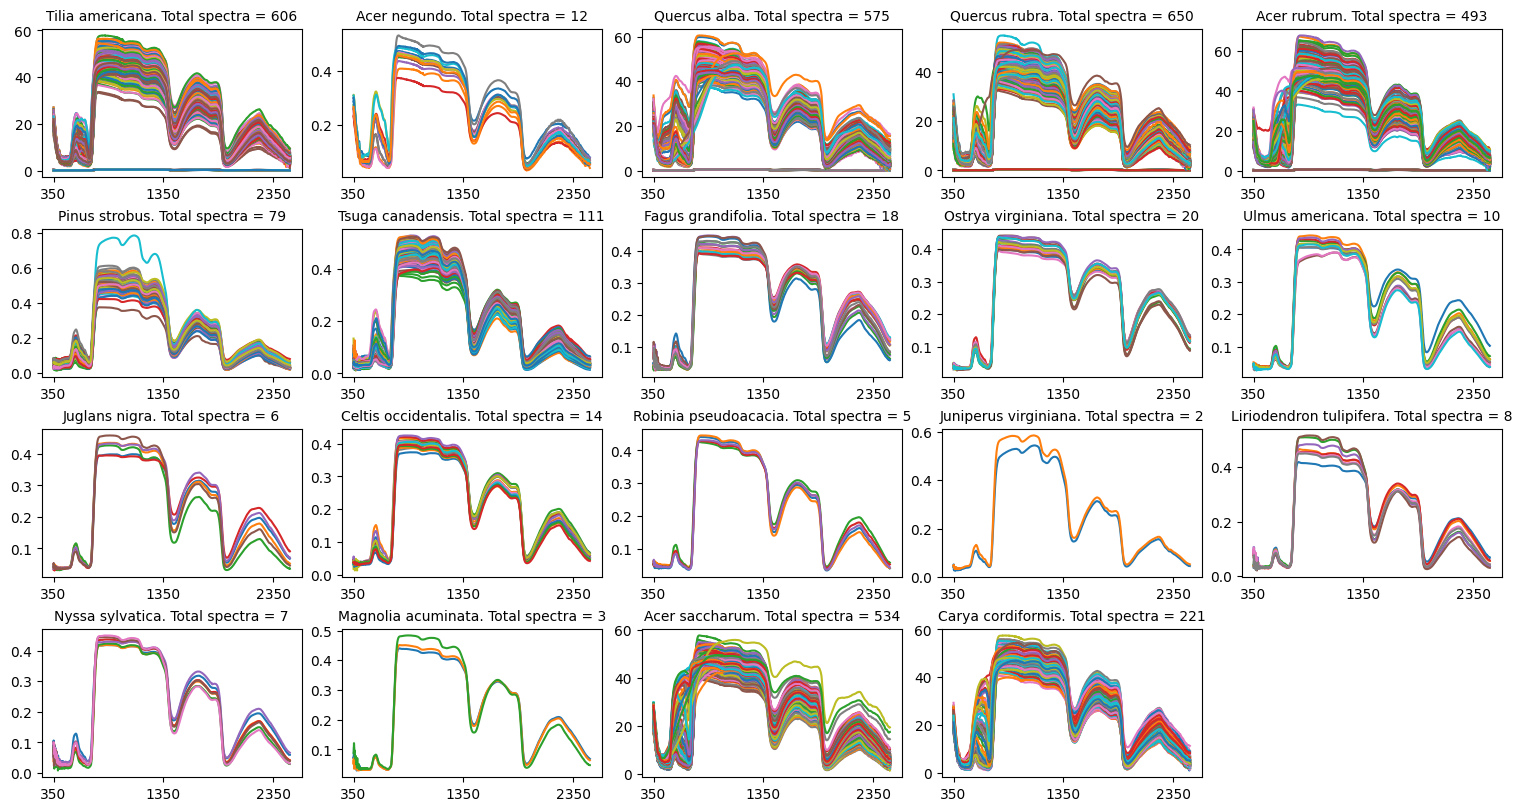

In [8]:
unique_spp = spectra_df.index.unique()
fig = plt.figure(figsize=(15,8), constrained_layout=True)
columns = 5
rows = int(len(unique_spp)/columns)+1
for i, item in enumerate(unique_spp):
    # transpose and plot species
    spp_df = spectra_df.loc[item]
    ax = fig.add_subplot(rows, columns, i+1)
    spp_df.T.plot(ax=ax, legend=None)
    ax.set_title(f"{item}. Total spectra = {len(spp_df.index)}", fontsize=10)

plt.show()

## Saving the spectra
Let's save the spectra we just retrieved as a CSV file.

In [9]:
spectra_df.to_csv('spectra_plant_species.csv')